<a href="https://colab.research.google.com/github/dBenazzi/trash-can/blob/main/programmazione_di_applicazioni_data_intensive/Predizione_Indice_Borsa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio: Predizione di un Indice di Borsa

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Proff. Gianluca Moro, Roberto Pasolini  
`nome.cognome@unibo.it`

## Setup

- Importare le librerie necessarie

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

## Predizione di un indice di borsa

- Un _indice_ in borsa è la sintesi del valore di diversi titoli azionari (_componenti_)
  - il valore dell'indice è una media (di solito ponderata) dei valori dei singoli titoli
- In questa esercitazione consideriamo l'indice _Standard & Poor 500_ (S&P 500), che ha per componenti [circa 500 grandi aziende degli USA](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies)
  - incluse ad es. Alphabet (Google), Facebook, Apple, ...
- L'obiettivo è generare modelli in grado di prevedere le variazioni dell'indice S&P 500, in modo da massimizzare il guadagno ottenuto investendo in un fondo che si basi su tale indice

## Estrazione dati

- I dati storici sull'andamento di S&P 500 e altri indici e titoli di borsa sono disponibili su diversi siti specializzati, ad es. [Yahoo! Finance](https://finance.yahoo.com/)
- Dal sito è possibile interattivamente ricercare titoli e indici e consultarne i dati attuali e storici, scaricandoli eventualmente in formato CSV
- È però spesso possibile estrarre i dati forniti anche tramite codice, effettuando opportune operazioni per importarli in strutture dati appropriate
- Esistono alcune librerie che forniscono funzioni di alto livello per importare dati da Yahoo! Finance e altri fonti simili
  - queste librerie gestiscono automaticamente il reperimento dei dati dagli URL corretti ed il loro parsing

### yfinance

- [yfinance](https://pypi.org/project/yfinance/) è una libreria per l'estrazione di dati da Yahoo! Finance in forma di oggetti Python facilmente interrogabili
- In particolare, la usiamo per ottenere i dati storici di titoli e indici in forma di DataFrame pandas
- Eseguire la seguente cella di codice per installare yfinance (e il package lxml necessario) nell'ambiente virtuale in uso
  - _nel caso di problemi con la libreria, i dati necessari per l'esercitazione sono disponibili anche in un file indicato sotto_

In [156]:
pip install yfinance lxml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- Importare il modulo `yfinance`, verificandone così la corretta installazione

In [157]:
import yfinance

- Per usare il modulo creiamo un oggetto `Ticker`, che rappresenta uno specifico titolo o indice
- Dobbiamo indicare il _simbolo_ del titolo o indice con cui vogliamo lavorare, che per S&P 500 è `^GSPC`

In [158]:
sp500 = yfinance.Ticker("^GSPC")

- Altri simboli di indici noti includono:
  - `^DJI`: Dow Jones Industrial Average
  - `^IXIC`: NASDAQ
  - `FTSEMIB.MI`: MIB (borsa di Milano)

- Da un `Ticker` possiamo usare il metodo `history` per ottenere un frame con i dati storici in un periodo specificato
  - con `start` e `end` specifichiamo l'intervallo di date desiderato
  - `actions=False` esclude alcune colonne con dati non disponibili per l'indice
- Scarichiamo i dati relativi agli anni dal 2001 al 2008

In [159]:
data = sp500.history(start="2001-01-01", end="2008-12-31", actions=False)

- _In caso di problemi con yfinance, decommentare ed eseguire la seguente cella per importare gli stessi dati da un file già scaricato da noi_

In [160]:
# data = pd.read_csv("https://git.io/Jfq8p", index_col="Date", parse_dates=["Date"])

In [161]:
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2001-01-02 00:00:00-05:00,1320.280029,1320.280029,1276.050049,1283.270020,1129400000
2001-01-03 00:00:00-05:00,1283.270020,1347.760010,1274.619995,1347.560059,1880700000
2001-01-04 00:00:00-05:00,1347.560059,1350.239990,1329.140015,1333.339966,2131000000
2001-01-05 00:00:00-05:00,1333.339966,1334.770020,1294.949951,1298.349976,1430800000
2001-01-08 00:00:00-05:00,1298.349976,1298.349976,1276.290039,1295.859985,1115500000


- Ciascuna riga corrisponde ad una data, indicata nell'indice `Date`
  - non sono presenti le righe relative a giorni di chiusura del mercato
- `Open` e `Close` riportano per ogni data il valore dell'indice all'apertura e alla chiusura del mercato
- `High` e `Low` riportano i massimi e minimi giornalieri
- `Volume` è il numero di titoli scambiati in giornata

- Per comodità, estraiamo una serie per ciascuna colonna, per potersi riferire ad esse con un unico nome
  - notare che la serie `open` sovrascrive la funzione `open` di Python, quest'ultima rimane accessibile come `__builtins__.open`

In [162]:
open = data["Open"]
high = data["High"]
low = data["Low"]
close = data["Close"]
volume = data["Volume"]

- Possiamo tracciare un grafico dell'andamento del titolo
  - prendiamo come riferimento ad es. il valore dell'apertura

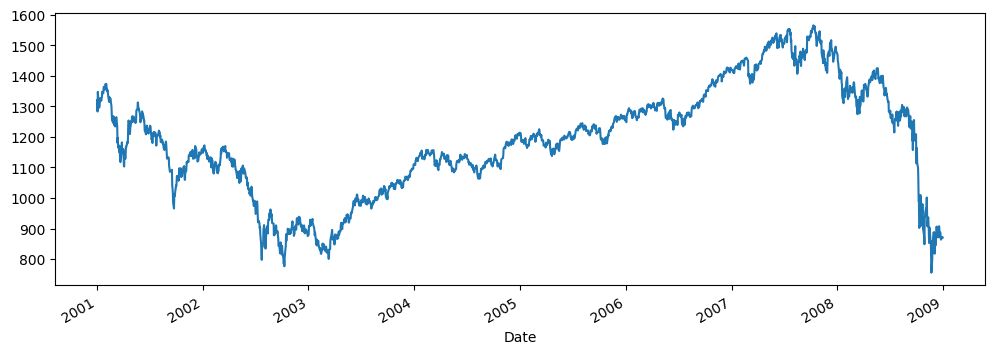

In [163]:
open.plot(figsize=(12, 4));

- Esistono altri tipi di grafici appositi per mostrare l'andamento di titoli di borsa, ad es. i _candlestick chart_ ("grafici a candela")
  - per disegnarli si veda la libreria `mplfinance`, estensione di matplotlib

### Esercizio 1: Analisi esplorativa

- **(1a)** Estrarre le statistiche principali (media, dev. standard, ...) delle varie colonne (Open, Close, ...)
- **(1b)** Ottenere una serie `hlm` col valore medio tra il massimo e il minimo giornalieri
- **(1c)** Estrarre le statistiche principali di tale serie
- **(1d)** Estrarre le statistiche principali di `hlm` suddivise per anno

In [164]:
# a
for e in data.columns:
  print(e, ":\n", data[e].describe())

Open :
 count    2010.000000
mean     1187.474553
std       180.326713
min       755.840027
25%      1084.077454
50%      1190.229980
75%      1304.137512
max      1564.979980
Name: Open, dtype: float64
High :
 count    2010.000000
mean     1195.450877
std       179.563836
min       798.549988
25%      1091.872528
50%      1195.979980
75%      1311.609985
max      1576.089966
Name: High, dtype: float64
Low :
 count    2010.000000
mean     1178.652866
std       181.296274
min       741.020020
25%      1075.594971
50%      1183.635010
75%      1295.272522
max      1555.459961
Name: Low, dtype: float64
Close :
 count    2010.000000
mean     1187.302095
std       180.433599
min       752.440002
25%      1083.882446
50%      1190.229980
75%      1304.324982
max      1565.150024
Name: Close, dtype: float64
Volume :
 count    2.010000e+03
mean     2.257390e+09
std      1.379745e+09
min      3.560700e+08
25%      1.359225e+09
50%      1.693850e+09
75%      2.696278e+09
max      1.145623e+10
Na

In [165]:
hlm = (high + low)/2

In [166]:
hlm.describe()

count    2010.000000
mean     1187.051872
std       180.340289
min       771.110016
25%      1084.422501
50%      1189.442474
75%      1303.409988
max      1561.404968
dtype: float64

In [167]:
hlm.groupby(hlm.index.year).describe()

,count,mean,std,min,25%,50%,75%,max
Date,,,,,,,,
2001,248.0,1193.689196,86.865939,964.644989,1136.603775,1191.602539,1254.802490,1374.015015
2002,252.0,993.878335,114.077936,787.174988,895.336250,968.600006,1107.357483,1170.260010
2003,252.0,964.632222,78.602540,796.545013,896.213753,985.644989,1028.395004,1109.385010
2004,252.0,1130.409743,31.444939,1064.149963,1110.626266,1126.692505,1142.978729,1214.940002
2005,252.0,1207.289366,29.553492,1144.360046,1187.330002,1204.835022,1228.238770,1271.455017
2006,251.0,1310.053308,50.920535,1225.375000,1273.427521,1296.955017,1336.912506,1428.554993
2007,251.0,1476.593744,44.426483,1376.034973,1442.607483,1475.619995,1512.577515,1561.404968
2008,252.0,1221.611490,190.555138,771.110016,1150.651276,1289.319977,1359.184998,1456.919983


## Obiettivo: prevedere il valore di chiusura a inizio giornata

- Assumiamo che un agente investa quotidianamente sull'indice S&P 500
- Vuole un modello che **preveda all'inizio di ogni giornata** `d` il valore `close[d]` dell'indice **a fine giornata**
- La variabile `close` è quindi quella da prevedere, la _y_

In [168]:
y = close

- Ma quali sono le variabili predittive, le _X_?
- `high`, `low` e `volume` **non possono essere utilizzate** in quanto il loro valore **non è noto** a inizio giornata
- Solamente il valore `open[d]` è noto al momento della predizione

- Iniziamo creando un modello di predizione solamente sulla variabile `open`
- Creiamo un dizionario `features` con le variabili predittive, in questo caso solamente il valore di `open`

In [169]:
features = {"Open": open}

- Incapsuliamo le variabili in un `DataFrame`

In [170]:
X = pd.DataFrame(features)

In [171]:
X.head(3)

,Open
Date,
2001-01-02 00:00:00-05:00,1320.280029
2001-01-03 00:00:00-05:00,1283.270020
2001-01-04 00:00:00-05:00,1347.560059


### Suddivisione dati

- Effettuiamo una prima suddivisione dei dati in training e validation set
- Avendo una serie temporale, è comune utilizzare come training i dati fino ad una data specifica e come validation quelli successivi
- Definiamo una funzione `split_before_2005` che, dati `X` e `y`, restituisca in una tupla con 4 elementi
  - un training set `X_train` e `y_train` con i dati fino al 2004
  - un validation set `X_val` e `y_val` con i dati dal 2005 in poi
- Utilizziamo tale funzione per suddividere i dati `X` e `y` definiti sopra

In [172]:
def split_before_2005(X, y):
    is_train = X.index.year < 2005
    X_train = X.loc[is_train]
    y_train = y.loc[is_train]
    X_val = X.loc[~is_train]
    y_val = y.loc[~is_train]
    return X_train, X_val, y_train, y_val

In [173]:
X_train, X_val, y_train, y_val = split_before_2005(X, y)

### Esercizio 2: Addestramento e validazione modelli

Usando training e validation set creati sopra, addestrare ciascuno dei seguenti modelli ed ottenerne il coefficiente R²
- **(2a)** regressione lineare semplice
- **(2b)** regressione polinomiale di grado 10 con regolarizzazione L2 ($\alpha=1$)
- **(2c)** regressione polinomiale di grado 3 con standardizzazione delle feature

In [174]:
# import necessari
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

def fit_and_score(model, x_train, y_train, x_test, y_test):
  model.fit(x_train, y_train)
  print("model score: ", model.score(x_test, y_test))

def plot_mdl_on_data(model, X_train, y_train, X_data):
  plt.plot(X_data, y_train, "r.", label="input data")
  plt.plot(X_data, model.predict(X_train), "b", label="prevision")
  plt.legend()
  plt.xlim(int(X_data.min()), int(X_data.median()))
  plt.ylim(y_train.min(), y_train.max())

In [175]:
# a
mdl = LinearRegression()
fit_and_score(mdl, X_train, y_train, X_val, y_val)

model score:  0.9886049726011812


In [176]:
# b
mdl = Pipeline([
    ("poly", PolynomialFeatures(5, include_bias=False)),
    ("mdl", Ridge(alpha=1))
])
fit_and_score(mdl, X_train, y_train, X_val, y_val)

model score:  0.9824657739540624


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.40055e-33): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [177]:
mdl = Pipeline([
    ("poly", PolynomialFeatures(3, include_bias=False)),
    ("scaler", StandardScaler()),
    ("mdl", Ridge(alpha=1))
])
fit_and_score(mdl, X_train, y_train, X_val, y_val)

model score:  0.9887404014357926


(776.0, 1098.0)

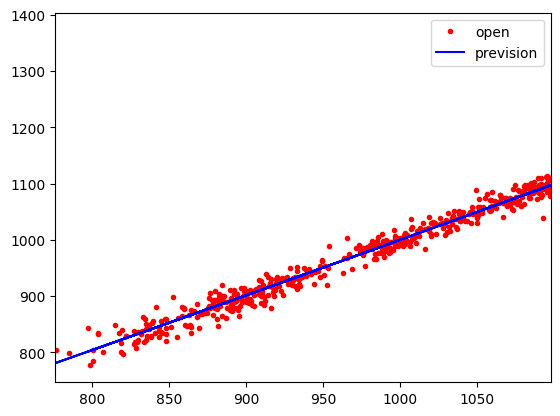

In [178]:
plt.plot(X_train, y_train, "r.", label="open")
plt.plot(X_train, mdl.predict(X_train), "b", label="prevision")
plt.legend()
plt.xlim(int(X_train.min()), int(X_train.median()))

## Simulazione di trading

- I punteggi R² dei modelli (anche i più semplici) risultano molto alti
- Questo è dovuto al fatto che i valori di `open` e `close` sono generalmente molto correlati
- Tuttavia, questo non indica quanto il modello sia in grado di cogliere le piccole variazioni giornaliere tra i due
- Queste variazioni sono determinanti nel guidare un investitore
- Per avere un'idea dell'utilità effettiva del modello, calcoliamo il **guadagno effettivo** che avrebbe un investitore utilizzando il modello

### Protocollo di trading

Assumiamo un investitore che
- all'inizio di ogni giornata $d$ confronta il valore di apertura noto $O_d$ col valore di chiusura predetto dal modello $\hat{C}_d$
- se è previsto un rialzo ($\hat{C}_d > O_d$), compra un titolo e lo rivende a fine giornata, con un guadagno di $C_d-O_d$
- se è previsto un ribasso ($\hat{C}_d < O_d$) vende (allo scoperto) un titolo e lo ricompra a fine giornata, con un guadagno di $O_d-C_d$ (l'opposto del primo caso)

Possiamo definire una metrica "guadagno" per validare il modello, che restituisca il guadagno totale di un investitore che opera nel periodo a cui si riferisce il validation set

### Esercizio 3: Implementazione protocollo di trading

Completare l'implementazione di `gain` in modo che, date le serie di valori di chiusura reali `C` e predetti `C_pred`, restituisca il guadagno di un investitore secondo le specifiche sopra
- la serie di valori di apertura `O` è ricavata dalla serie completa `open` usando `reindex_like` per selezionare esattamente le date di `C`
- definire la serie `CO_diff` come la differenza $C_d-O_d$
- definire le serie booleane `growth` e `decline` che indicano in quali giorni viene *previsto* un rialzo o un ribasso del valore
- restituire la somma dei guadagni ottenuti da acquisto+vendita nei giorni `growth` e vendita+acquisto nei giorni `decline`

In [179]:
def gain(C, C_pred):
    O = open.reindex_like(C)
    CO_diff = C - O
    growth = C_pred > O
    decline = ~growth
    return CO_diff[growth].sum() - CO_diff[decline].sum()

### Calcolo del ROI

- Il ROI (_Return on Investment_) esprime il guadagno di una o più operazioni in borsa in rapporto all'investimento iniziale
- La cifra investita in questo caso è pari al valore d'apertura del titolo che varia giornalmente
- Per stimare il ROI usiamo la media di tale valore nel periodo di investimento
- Definiamo una nuova funzione `roi`, che riusa il guadagno `gain` definito sopra e lo rapporta all'investimento medio

In [180]:
def roi(C, C_pred):
    mean_open = open.reindex_like(C).mean()
    return gain(C, C_pred) / mean_open

- Definiamo una funzione `print_eval` per stampare le metriche di valutazione del modello
  - come le altre volte, dato il validation set e un modello da validare, si ottengono le predizioni e le si usano per calcolare le metriche
  - questa volta però mostriamo guadagno e ROI al posto delle metriche ordinarie

In [181]:
def print_eval(X, y, model):
    preds = model.predict(X)
    print("Gain: {:.2f}$".format(gain(y, preds)))
    print(" ROI: {:.3%}".format(roi(y, preds)))

- Valutiamo ad esempio guadagno e ROI su un modello di regressione lineare semplice
- Si ottiene un ROI basso, intorno al 5\%

In [182]:
model = LinearRegression()
model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

Gain: 61.36$
 ROI: 4.705%


## Introduzione di nuove feature

- Abbiamo addestrato un modello a prevedere il valore giornaliero di chiusura $C_d$ a partire da quello di apertura corrispondente $O_d$
- Abbiamo però visto con la stima di guadagno e ROI che tale modello non è efficace
- Per ottenere predizioni più affidabili per ciascuna giornata $d$, possiamo però integrare **informazioni note dai giorni precedenti** a $d$
- Vediamo come aggiungere tali informazioni in **nuove variabili** su cui basare le predizioni

- Le serie forniscono il metodo `shift`, con cui è possibile ottenerne i **valori slittati in avanti** di un numero di posizioni dato
- Data ad esempio la serie `open`...

In [183]:
open   .head(4)

Date
2001-01-02 00:00:00-05:00    1320.280029
2001-01-03 00:00:00-05:00    1283.270020
2001-01-04 00:00:00-05:00    1347.560059
2001-01-05 00:00:00-05:00    1333.339966
Name: Open, dtype: float64

- ...con `shift(2)` otteniamo gli stessi dati slittati in avanti di 2 giorni

In [184]:
open.shift(2)   .head(4)

Date
2001-01-02 00:00:00-05:00            NaN
2001-01-03 00:00:00-05:00            NaN
2001-01-04 00:00:00-05:00    1320.280029
2001-01-05 00:00:00-05:00    1283.270020
Name: Open, dtype: float64

- Nei primi 2 giorni sono inseriti valori NaN, non essendo noti i valori dei giorni precedenti

- Possiamo usare `shift` per generare le variabili che si riferiscono ai dati dei giorni precedenti
- Definiamo ad esempio un nuovo insieme di feature dove, al valore di apertura del giorno corrente $O_d$, aggiungiamo quelli dei due giorni precedenti $O_{d-1}$ e $O_{d-2}$

In [185]:
features = {
    "Open": open,
    "OpenLag1": open.shift(1),
    "OpenLag2": open.shift(2),
}

- Come sopra, creiamo un frame con i dati derivanti da tali feature

In [186]:
X = pd.DataFrame(features)

In [187]:
X.head(5)

,Open,OpenLag1,OpenLag2
Date,,,
2001-01-02 00:00:00-05:00,1320.280029,NaN,NaN
2001-01-03 00:00:00-05:00,1283.270020,1320.280029,NaN
2001-01-04 00:00:00-05:00,1347.560059,1283.270020,1320.280029
2001-01-05 00:00:00-05:00,1333.339966,1347.560059,1283.270020
2001-01-08 00:00:00-05:00,1298.349976,1333.339966,1347.560059


- Otteniamo così un frame con tre variabili invece di una
- Nelle prime righe abbiamo però dei valori mancanti
- Utilizziamo il metodo `dropna` per eliminare tutte le righe con uno o più valori mancanti
  - `inplace=True` indica di modificare `X` invece di restituire un frame nuovo

In [188]:
X.dropna(inplace=True)

In [189]:
X.head(5)

,Open,OpenLag1,OpenLag2
Date,,,
2001-01-04 00:00:00-05:00,1347.560059,1283.270020,1320.280029
2001-01-05 00:00:00-05:00,1333.339966,1347.560059,1283.270020
2001-01-08 00:00:00-05:00,1298.349976,1333.339966,1347.560059
2001-01-09 00:00:00-05:00,1295.859985,1298.349976,1333.339966
2001-01-10 00:00:00-05:00,1300.800049,1295.859985,1298.349976


- Ora tutte le righe di `X` sono utilizzabili per addestrare e validare il modello
- Avendo filtrato le righe di `X` dobbiamo filtrare allo stesso modo anche `y`: utilizziamo `reindex_like` per selezionare le stesse etichette (ovvero le date) nella serie `close`

In [190]:
y = close.reindex_like(X)

In [191]:
y.head(5)

Date
2001-01-04 00:00:00-05:00    1333.339966
2001-01-05 00:00:00-05:00    1298.349976
2001-01-08 00:00:00-05:00    1295.859985
2001-01-09 00:00:00-05:00    1300.800049
2001-01-10 00:00:00-05:00    1313.270020
Name: Close, dtype: float64

- Riutilizziamo `split_before_2005` su `X` e `y` aggiornati per ottenere i training e validation set aggiornati

In [192]:
X_train, X_val, y_train, y_val = split_before_2005(X, y)

### Esercizio 4: Funzione per la generazione di training e validation set

- Creare una funzione `prepare_data` che automatizzi i passaggi sopra
  - accettare in input un dizionario di variabili predittive `features` (simile a quello sopra) e una variabile da predire `target`
  - creare il frame `X` con le variabili predittive rimuovendo le righe con valori mancanti
  - creare la serie `y` con i valori della variabile da predire corrispondenti alle righe selezionate di `X`
  - restituire `X` e `y`

In [193]:
def prepare_data(features, target):
    X = pd.DataFrame(features)
    X.dropna(inplace=True)
    y = target.reindex_like(X)
    return X, y

## Modello sulle differenze

- Con l'aggiunta delle feature, la rendita del modello aumenta ma è ancora scarsa

Gain: 107.00$
 ROI: 8.205%


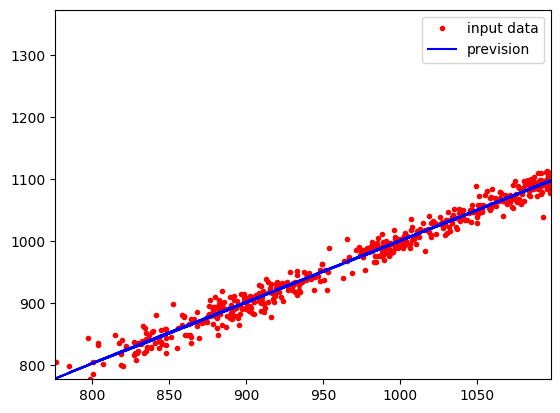

In [194]:
model = LinearRegression()
model.fit(X_train, y_train)
print_eval(X_val, y_val, model)
plot_mdl_on_data(model, X_train, y_train, X_train.iloc[:,0])

- Finora abbiamo usato nei modelli, sia come variabili predittive che da prevedere, i valori _assoluti_ di apertura e chiusura del mercato
- Tali valori seguono dei trend di lungo periodo e possono essere molto diversi in periodi differenti
  - si può notare ad esempio l'effetto della [crisi economica iniziata nel 2007](https://it.wikipedia.org/wiki/Grande_recessione)
- Nel nostro scenario siamo più interessati alle variazioni giornaliere, indipendentemente dai valori assoluti
- Revisioniamo i passaggi svolti sopra per utilizzare come variabili le differenze tra questi valori

- Iniziamo definendo come variabile la differenza $\Delta_d=C_d-O_d$ tra il valore di chiusura giornaliero $C_d$ e quello di apertura $O_d$

In [195]:
delta = close - open

- Poniamo questo come il valore che **deve essere predetto** dal modello
- L'investitore agirà in base alla predizione $\hat{\Delta}_d$ in modo analogo a prima
  - se $\hat{\Delta}_d > 0$, acquista un titolo a inizio giornata e lo rivende alla fine
  - se $\hat{\Delta}_d < 0$, vende un titolo a inizio giornata e lo ricompra alla fine

### Esercizio 5: Funzioni per guadagno e ROI sulle differenze

- Reimplementare la funzione `gain` in modo che consideri come input i valori reali e predetti di $\Delta_d=C_d-O_d$ piuttosto che di $C_d$
  - la funzione `roi` rimane invariata, la riportiamo con i nomi delle variabili aggiornate

In [209]:
def gain(D, D_pred):
    growth = D_pred > 0
    decline = ~growth
    return D[growth].sum() - D[decline].sum()

def roi(D, D_pred):
    mean_open = open.reindex_like(D).mean()
    return gain(D, D_pred) / mean_open

- Come variabili predittive, possiamo considerare i valori della variabile da predire $\Delta_d$ negli $N$ giorni precedenti: $\Delta_{d-1},\ldots,\Delta_{d-N}$
- Consideriamo ad esempio i valori nei 3 giorni precedenti
  - usiamo una comprehension per costruire un dizionario con le variabili `DeltaLag{i}` con `i` variabile

In [197]:
features = {
    "DeltaLag{}".format(i): delta.shift(i)
    for i in range(1, 4)
}

- Usiamo le funzioni già create sopra per ottenere training e validation set con queste nuove variabili

In [198]:
X, y = prepare_data(features, delta)
X_train, X_val, y_train, y_val = split_before_2005(X, y)

- Addestriamo e validiamo un modello di regressione lineare

In [199]:
model = LinearRegression()
model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

Gain: 1308.40$
 ROI: 100.329%


- Con questi accorgimenti, otteniamo un modello che garantisce un guadagno molto maggiore

## Confronto con un modello casuale

- Per avere una valutazione più completa del modello ottenuto, possiamo metterlo a confronto con quello che accadrebbe prendendo decisioni casuali
- Consideriamo un modello che predica dei valori $\hat{\Delta}_d$ casuali, ma con la stessa distribuzione dei valori $\Delta_d$ reali
- Disegnando un istogramma, vediamo che $\Delta_d$ ha una distribuzione normale

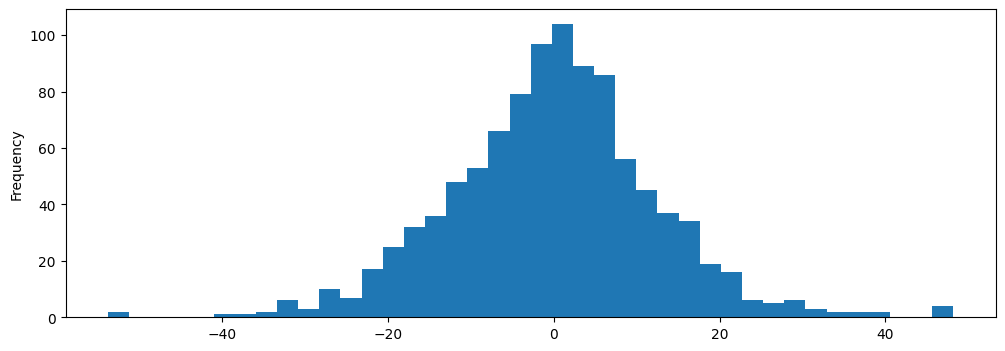

In [200]:
y_train.plot.hist(bins=40, figsize=(12, 4));

- Consideriamo una distribuzione normale con media e deviazione standard pari a quelle di `y_train` e generiamo tanti campioni quanti i valori in `y_val`

In [201]:
np.random.seed(42)
random_preds = np.random.normal(
    y_train.mean(),   # centro (media), circa 0
    y_train.std(),    # scala (dev. standard)
    len(y_val)        # numero di campioni
)

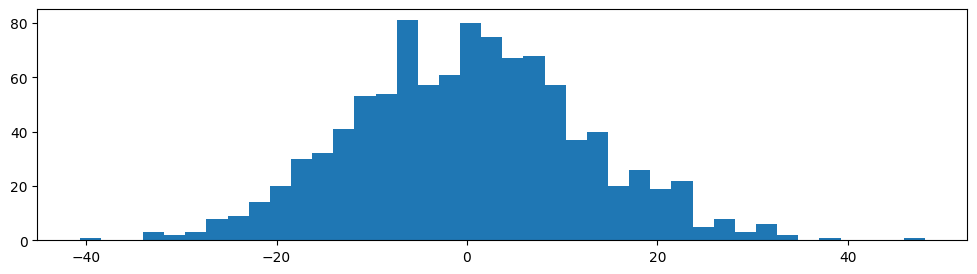

In [202]:
plt.figure(figsize=(12, 3))
plt.hist(random_preds, bins=40);

- Valutiamo guadagno e ROI utilizzando i campioni generati al posto delle predizioni del modello

In [203]:
gain(y_val, random_preds)

-271.2789306640625

In [204]:
roi(y_val, random_preds)

-0.20801836780762534

- In questo caso otteniamo un valore negativo, ovvero una perdita

### Esercizio 6: Test multipli su modello casuale

- Per valutare con maggiore affidabilità l'efficacia di un modello casuale, dobbiamo eseguire test multipli con seed differenti
- Calcolare il ROI medio su 1.000 test con predizioni casuali come quello sopra, utilizzando un seed diverso in ciascuna
- Si dovrebbe ottenere un ROI medio prossimo allo 0

In [210]:
u = y_train.mean()
std = y_train.std()
values = len(y_val)
roi_vals = []
for i in range(1000):
  np.random.seed(i)
  random_preds = np.random.normal(u, std, values)
  roi_vals.append(roi(y_val, random_preds))
np.mean(roi_vals)

0.01929211255212092

## Validazione k-fold per serie temporali

- Nella cross validation a _k_ fold ordinaria, i dati vengono divisi in _k_ fold mescolati casualmente
- Nel caso come questo di una serie temporale, vogliamo però mantenere l'ordine temporale in training e validation set
- Come alternativa allo split `KFold`, scikit-learn offre il `TimeSeriesSplit(k)` per questa situazione
  - il dataset è diviso in _k_+1 fold contigui di pari dimensioni
  - ogni split _i_ da 1 a _k_ contiene i primi _i_ fold come training set e il _i+1_-esimo come validation set

- Definiamo un `TimeSeriesSplit` con 3 split

In [211]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(3)

- Vediamo ad esempio come suddivide i dati in `X`: gli 8 anni dei dati sono divisi in 4 gruppi da 2

In [212]:
for i, (train, val) in enumerate(tss.split(X), start=1):
    print(f"FOLD {i}")
    train_dates = X.index[train]
    val_dates = X.index[val]
    print(f"Training set da {train_dates.min()} a {train_dates.max()}")
    print(f"Validation set da {val_dates.min()} a {val_dates.max()}")

FOLD 1
Training set da 2001-01-05 00:00:00-05:00 a 2003-01-10 00:00:00-05:00
Validation set da 2003-01-13 00:00:00-05:00 a 2005-01-06 00:00:00-05:00
FOLD 2
Training set da 2001-01-05 00:00:00-05:00 a 2005-01-06 00:00:00-05:00
Validation set da 2005-01-07 00:00:00-05:00 a 2007-01-04 00:00:00-05:00
FOLD 3
Training set da 2001-01-05 00:00:00-05:00 a 2007-01-04 00:00:00-05:00
Validation set da 2007-01-05 00:00:00-05:00 a 2008-12-30 00:00:00-05:00


```
         2001   2002   2003   2004   2005   2006   2007   2008
       +------+------+------+------+------+------+------+------+
Fold 1 |   Training  |  Validation |######## non usato ########|
       +------+------+------+------+------+------+------+------+
Fold 2 |          Training         |  Validation |# non usato #|
       +------+------+------+------+------+------+------+------+
Fold 3 |                 Training                |  Validation |
       +------+------+------+------+------+------+------+------+
```

- Per eseguire la cross validation, dobbiamo stabilire anche la metrica di valutazione da utilizzare
- Prendiamo come riferimento il ROI, per cui abbiamo implementato la funzione `roi`
- Per utilizzarla come metrica al posto di quelle predefinite dobbiamo incapsularla in un oggetto _scorer_ con la funzione `make_scorer`
  - `greater_is_better=True` specifica che valori più alti indicano modelli migliori, al contrario delle misure d'errore

In [213]:
from sklearn.metrics import make_scorer
roi_scorer = make_scorer(roi, greater_is_better=True)

- Possiamo ora utilizzare la funzione `cross_validate`, specificando
  - il modello da validare
  - i dati
  - il criterio di suddivisione in fold (oggetto `TimeSeriesSplit`)
  - la metrica di valutazione (il ROI)
- Usiamo come esempio la regressione lineare semplice

In [214]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(
    LinearRegression(),
    X, y,
    cv=tss,
    scoring=roi_scorer,
)

- Estraiamo i punteggi ottenuti nei tre fold e calcoliamo la media

In [215]:
cv_results["test_score"]

array([-0.14443616,  0.10888946,  0.74112849])

In [216]:
cv_results["test_score"].mean()

0.23519392952726648

- Vediamo che il ROI medio è 23,5\%, ma molto variabile da un periodo d'applicazione all'altro, probabilmente anche per via dei training set di diversa durata (2, 4, 6 anni)
  - notare che questi ROI sono calcolati su periodi di soli due anni, contro i quattro del validation set fisso usato prima

## Grid search

- Possiamo riutilizzare gli stessi componenti della cross validation "semplice" in una grid search per tarare gli iperparametri dei modelli più avanzati
- Prendiamo ad esempio come modello base la regressione polinomiale con o senza standardizzazione delle feature generate

In [217]:
model = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scale", None),
    ("regr", LinearRegression())
])

- Definiamo la griglia degli iperparametri variabili: applicazione o non della standardizzazione e grado del polinomio
  - includiamo per confronto anche il grado 1, ovvero la regressione lineare standard

In [218]:
grid = {
    "scale": [None, StandardScaler()],
    "poly__degree": list(range(1, 7))
}

- Creiamo il modello grid search specificando tutti i parametri
  - modello base con iperparametri fissi
  - griglia dei iperparametri variabili
  - criterio di cross validation
  - metrica di valutazione

In [219]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(model, grid, cv=tss, scoring=roi_scorer)

- Addestriamolo quindi su tutti i dati

In [220]:
gs.fit(X, y);

- Reperiamo e analizziamo i risultati ottenuti

In [221]:
gs_results = pd.DataFrame(gs.cv_results_)

In [222]:
# stampo le 5 configurazioni migliori
gs_results.sort_values("mean_test_score", ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,param_scale,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
8,0.010748,0.001552,0.004393,0.000405,5,None,"{'poly__degree': 5, 'scale': None}",-0.042530,0.189004,0.770411,0.305628,0.341974,1
9,0.012532,0.001512,0.004339,0.000062,5,StandardScaler(),"{'poly__degree': 5, 'scale': StandardScaler()}",-0.042530,0.189004,0.770411,0.305628,0.341974,1
0,0.006157,0.001471,0.002987,0.000590,1,None,"{'poly__degree': 1, 'scale': None}",-0.144436,0.108889,0.741128,0.235194,0.372398,3
1,0.004803,0.000197,0.002493,0.000029,1,StandardScaler(),"{'poly__degree': 1, 'scale': StandardScaler()}",-0.144436,0.108889,0.741128,0.235194,0.372398,3
6,0.018718,0.002004,0.006924,0.000250,4,None,"{'poly__degree': 4, 'scale': None}",-0.028171,0.097567,0.272940,0.114112,0.123484,5


- Le migliori configurazioni in questo caso sono quelle con le feature di 5° grado (la standardizzazione non fa differenza)

### Esercizio 7: Grid search su kernel ridge

- Effettuare la grid search su un modello kernel ridge
  - con kernel `rbf` con `gamma` pari a $10^{-3},10^{-2},10^{-1}$
  - con peso di regolarizzazione `alpha` pari a $10^{-3},10^{-2},\ldots,10^2$
    - si può usare `np.logspace`
  - con o senza standardizzazione delle feature in ingresso
- Stampare come sopra un frame con le 5 configurazioni migliori

In [223]:
from sklearn.kernel_ridge import KernelRidge

In [224]:
mdl = Pipeline([
    ("scaler", None),
    ("mdl", KernelRidge(kernel="rbf"))
])
grid = {
    "scaler": [None, StandardScaler()],
    "mdl__alpha": np.logspace(-3, 2, 6),
    "mdl__gamma": [0.001, 0.01, 0.1]
}

In [230]:
gs = GridSearchCV(mdl, grid, cv=tss, scoring=roi_scorer)
gs.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('scaler', None),
                                       ('mdl', KernelRidge(kernel='rbf'))]),
             param_grid={'mdl__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'mdl__gamma': [0.001, 0.01, 0.1],
                         'scaler': [None, StandardScaler()]},
             scoring=make_scorer(roi))

In [232]:
res = pd.DataFrame(gs.cv_results_)
res.sort_values("mean_test_score", ascending=False).head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mdl__alpha,param_mdl__gamma,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
17,0.170786,0.101799,0.041931,0.013882,0.1,0.1,StandardScaler(),"{'mdl__alpha': 0.1, 'mdl__gamma': 0.1, 'scaler...",-0.179396,0.148859,0.987389,0.318950,0.491287,1
8,0.100321,0.065602,0.024469,0.010338,0.01,0.01,None,"{'mdl__alpha': 0.01, 'mdl__gamma': 0.01, 'scal...",0.095404,-0.035444,0.846344,0.302101,0.388527,2
2,0.175751,0.101782,0.058105,0.021386,0.001,0.01,None,"{'mdl__alpha': 0.001, 'mdl__gamma': 0.01, 'sca...",-0.135527,0.018342,0.949231,0.277349,0.479228,3
14,0.213107,0.156337,0.050101,0.019990,0.1,0.01,None,"{'mdl__alpha': 0.1, 'mdl__gamma': 0.01, 'scale...",0.087712,0.090150,0.605152,0.261005,0.243351,4


## Aggiunta di variabili predittive

- I modelli addestrati sopra sono basati solamente su tre variabili, ovvero i valori di $\Delta_d$ nei tre giorni precedenti a $d$
- Non stiamo utilizzando altre informazioni, quali le variazioni dei valori da un giorno all'altro e i massimi/minimi giornalieri
- Creiamo un nuovo insieme di variabili che tenga conto di queste altre informazioni

In [233]:
features = {}

- Inseriamo inizialmente le feature relative ai valori di $\Delta_d$ nei giorni precedenti, come prima

In [234]:
for n in range(1, 4):   # n da 1 a 3
    features["DeltaLag{}".format(n)] = delta.shift(n)

- Per cogliere le variazioni da un giorno all'altro, possiamo considerare le differenze tra valori di una stessa variabile tra giorni consecutivi
- Consideriamo ad esempio il valore di apertura $O_d$
- Possiamo usare come variabile la differenza $O_d-O_{d-1}$ di questo valore da quello del giorno precedente
  - anche questa variabile, come $\Delta_d$, è una differenza tra valori piuttosto che un valore assoluto: non viene influenzata dall'andamento di lungo periodo del mercato
- Possiamo ottenere questa variabile dalla differenza tra la serie `open` e lo `shift` di se stessa

In [235]:
open_diff = open - open.shift(1)

- Visualizziamo alcuni valori di tale variabile, affiancati a quelle da cui è ricavata

In [236]:
pd.DataFrame({
    "Open": open,
    "OpenLag1": open.shift(1),
    "OpenDiff": open_diff
}).head(5)

,Open,OpenLag1,OpenDiff
Date,,,
2001-01-02 00:00:00-05:00,1320.280029,NaN,NaN
2001-01-03 00:00:00-05:00,1283.270020,1320.280029,-37.010010
2001-01-04 00:00:00-05:00,1347.560059,1283.270020,64.290039
2001-01-05 00:00:00-05:00,1333.339966,1347.560059,-14.220093
2001-01-08 00:00:00-05:00,1298.349976,1333.339966,-34.989990


- scikit-learn offre un metodo `diff(n)` per ottenere direttamente la differenza tra una serie e il suo `shift(n)`

In [237]:
open.diff()   .head()

Date
2001-01-02 00:00:00-05:00          NaN
2001-01-03 00:00:00-05:00   -37.010010
2001-01-04 00:00:00-05:00    64.290039
2001-01-05 00:00:00-05:00   -14.220093
2001-01-08 00:00:00-05:00   -34.989990
Name: Open, dtype: float64

- Il metodo `equals` permette di verificare che una serie (o frame) sia identica ad un'altra

In [ ]:
open.diff() .equals( open - open.shift(1) )

True

- Aggiungiamo ad esempio alle feature le differenze da un giorno all'altro dei valori di `high` e `low`, ovvero i massimi e minimi di giornata
  - tenere presente che ad ogni giornata $d$ non conosciamo subito $H_d$ e $L_d$, per cui utilizziamo invece $H_{d-1}$ e $L_{d-1}$
  - ad es., per ottenere $H_{d-1}-H_{d-2}$, $H_{d-2}-H_{d-3}$ e $H_{d-3}-H_{d-4}$ prendiamo $H_{d}-H_{d-1}$ e applichiamo lo `shift` di 1, 2 e 3 giorni
  - _evitiamo quì di usare le differenze $O_d$ e $C_{d-1}$, in quanto in questi dati sono molto correlate a $\Delta_d$_

In [238]:
for n in range(1, 4): # n da 1 a 3
    features["HighDiff{}".format(n)] = high.diff().shift(n)
    features["LowDiff{}".format(n)] = low.diff().shift(n)

- Usiamo la funzione `prepare_data` definita sopra per creare il dataset completo con le variabili scelte

In [239]:
X, y = prepare_data(features, delta)

- Possiamo visualizzare le prime righe del frame con le variabili generate

In [240]:
X.head(5)

,DeltaLag1,DeltaLag2,DeltaLag3,HighDiff1,LowDiff1,HighDiff2,LowDiff2,HighDiff3,LowDiff3
Date,,,,,,,,,
2001-01-08 00:00:00-05:00,-34.989990,-14.220093,64.290039,-15.469971,-34.190063,2.479980,54.520020,27.479980,-1.430054
2001-01-09 00:00:00-05:00,-2.489990,-34.989990,-14.220093,-36.420044,-18.659912,-15.469971,-34.190063,2.479980,54.520020
2001-01-10 00:00:00-05:00,4.940063,-2.489990,-34.989990,13.369995,18.849976,-36.420044,-18.659912,-15.469971,-34.190063
2001-01-11 00:00:00-05:00,12.469971,4.940063,-2.489990,2.040039,-7.859985,13.369995,18.849976,-36.420044,-18.659912
2001-01-12 00:00:00-05:00,13.549927,12.469971,4.940063,18.429932,22.439941,2.040039,-7.859985,13.369995,18.849976


### Esercizio 8: Test modelli con nuove feature

- **(8a)** Addestrare sui nuovi dati un modello di regressione lasso con $\alpha=3$ e verificare quali feature non vengono escluse
- **(8b)** Eseguire la cross validation di un modello di regressione lineare semplice, con gli stessi criteri di suddivisione dati e valutazione usati sopra
- **(8c)** Eseguire la grid search degli iperparametri di un modello kernel ridge, usando le stesse specifiche dell'esercizio 7

In [241]:
from sklearn.linear_model import Lasso

In [244]:
# a
mdl = Lasso(3)
mdl.fit(X, y)
pd.DataFrame(mdl.coef_, X.columns)

,0
DeltaLag1,-0.051997
DeltaLag2,-0.039001
DeltaLag3,0.043048
HighDiff1,0.000000
LowDiff1,-0.051650
HighDiff2,-0.007102
LowDiff2,-0.000000
HighDiff3,0.000000
LowDiff3,-0.028046


In [248]:
# b
results = cross_validate(LinearRegression(), X, y, cv=tss, scoring=roi_scorer)
np.mean(results["test_score"])

0.1810576917654021

In [249]:
# c
mdl = Pipeline([
    ("scaler", None),
    ("mdl", KernelRidge(kernel="rbf"))
])
grid = {
    "scaler": [None, StandardScaler()],
    "mdl__alpha": np.logspace(-3, 2, 6),
    "mdl__gamma": [0.001, 0.01, 0.1]
}
gs = GridSearchCV(mdl, grid, cv=tss, scoring=roi_scorer)
gs.fit(X, y)
res = pd.DataFrame(gs.cv_results_)
res.sort_values("mean_test_score", ascending=False).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mdl__alpha,param_mdl__gamma,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
15,0.111539,0.067973,0.018110,0.005547,0.1,0.01,StandardScaler(),"{'mdl__alpha': 0.1, 'mdl__gamma': 0.01, 'scale...",0.089293,0.002383,0.787928,0.293201,0.351619,1
14,0.103698,0.068644,0.021645,0.002807,0.1,0.01,None,"{'mdl__alpha': 0.1, 'mdl__gamma': 0.01, 'scale...",0.135564,0.206851,0.490796,0.277737,0.153440,2
7,0.136298,0.079999,0.028267,0.005630,0.01,0.001,StandardScaler(),"{'mdl__alpha': 0.01, 'mdl__gamma': 0.001, 'sca...",0.098224,-0.064361,0.679617,0.237827,0.319367,3


## Esercizi avanzati suggeriti

- Testare modelli con l'aggiunta di nuove feature non considerate quì, ad es. le differenze tra valori massimi e minimi nei giorni precedenti
- Cambiare il protocollo di trading in modo che venga svolta un'operazione di acquisto/vendita solo se il valore assoluto di $\hat{\Delta}_d$ supera una determinata soglia (per cui c'è più certezza di un rialzo/ribasso) e verificare come varia il ROI al variare di tale soglia
- Eseguire test su periodi differenti e/o con titoli/indici differenti